In [1]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.hed import HEDdetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

/home/gridsan/qwang/.conda/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.


In [2]:
version = '24511719'
epoch = '4'
step = '112594'
city_dic={'chicago': 'Chicago', 'dallas':'Dallas', 'la':'Los Angeles'}

In [3]:
model = create_model('./models/cldm_v15.yaml').cpu()
# model.load_state_dict(load_state_dict('./models/control_sd15_ini.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23691853/checkpoints/epoch=8-step=74483.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23745120/checkpoints/epoch=2-step=24494.ckpt', location='cuda:1'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23786778/checkpoints/epoch=12-step=106144.ckpt', location='cuda'))
# model.load_state_dict(load_state_dict('./lightning_logs/version_23786984/checkpoints/epoch=17-step=98531.ckpt', location='cuda'))
model.load_state_dict(load_state_dict('./lightning_logs/version_'+version+'/checkpoints/epoch='+epoch+'-step='+step+'.ckpt', location='cuda'))

model = model.cuda()
ddim_sampler = DDIMSampler(model)

No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./lightning_logs/version_24511719/checkpoints/epoch=4-step=112594.ckpt]


In [4]:
desc = {}
for c in ['chicago','la','dallas']:
    desc[c] = pd.read_csv("~/satellite_tiles_control/tile_descriptions/tile_descriptions_"+c+"_1114.csv").set_index(['xtile','ytile'])


In [5]:
import os
os.makedirs('./lightning_logs/version_'+version+'/image_log/', exist_ok=True)
os.makedirs('./lightning_logs/version_'+version+'/image_output/', exist_ok=True)

In [6]:
def process(x, y, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v=None, RGB=True):
    
    with torch.no_grad():
        input_image = cv2.imread("../satellite_tiles_control/satellite_tiles/"+str(zoom)+"/"+input_city+"/"+str(zoom)+"_"+str(x)+"_"+str(y)+".png")
        input_image = np.array(input_image)
        H,W,C = input_image.shape

        if v is None:
            detected_map = cv2.imread("../satellite_tiles_control/skeleton/"+str(zoom)+"/"+input_city+"/"+str(x)+"/"+str(y)+".png", cv2.IMREAD_UNCHANGED)
        else:
            detected_map = cv2.imread("../satellite_tiles_control/skeleton/"+str(zoom)+"/test/"+str(x)+"_"+str(y)+"_"+v+".png", cv2.IMREAD_UNCHANGED)
        detected_map = np.array(detected_map)    

        # convert 4-channel source image to 3-channel
        #make mask of where the transparent bits are
        trans_mask = detected_map[:,:,3] == 0

        #replace areas of transparency with white and not transparent
        detected_map[trans_mask] = [255, 255, 255, 255]

        #new image without alpha channel...
        detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGRA2BGR)        
        #OpenCV read images in BGR order.
        control = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)
        control = torch.from_numpy(control.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()

        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)
            
        cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
        un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                     shape, cond, verbose=False, eta=eta,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=un_cond)
            
        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

        if RGB:
            results = [x_samples[i] for i in range(num_samples)]
            detected_map = cv2.cvtColor(detected_map, cv2.COLOR_BGR2RGB)
        else:
            results = [cv2.cvtColor(x_samples[i], cv2.COLOR_RGB2BGR) for i in range(num_samples)]

        return [detected_map] + [input_image] + results


In [7]:
zoom = "16"
num_samples = 1
image_resolution = 512
strength = 1.0
guess_mode = False
detect_resolution = 512
ddim_steps = 20
scale = 9.0
seed = 5354
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

In [8]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16813'
ytile = '24355'

prompt = desc[input_city].loc[(int(xtile),int(ytile))]['final_description']
RGB=True
outputs0 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v='0', RGB=RGB)
outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v='1', RGB=RGB)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v='2', RGB=RGB)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v='3', RGB=RGB)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


In [9]:
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_0.png',outputs0[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_1.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_2.png',outputs2[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_3.png',outputs3[2]);

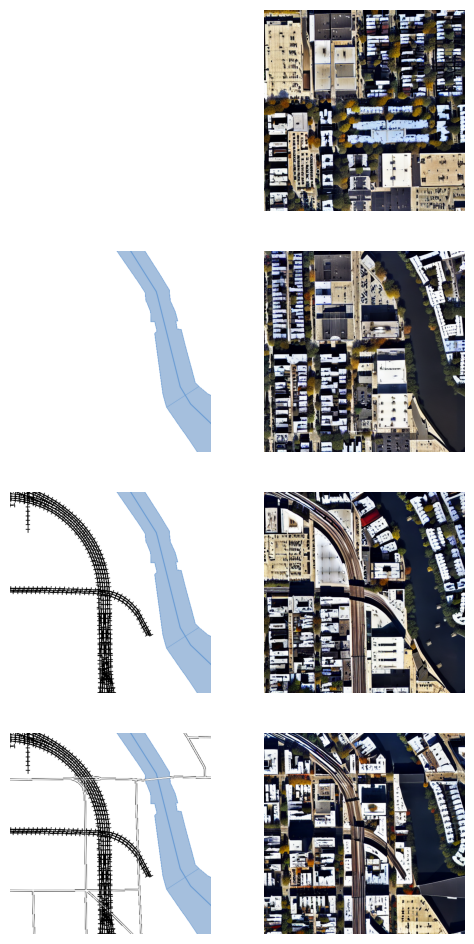

In [12]:
fig, ax = plt.subplots(4,2, figsize=(6,12))
ax[0,0].imshow(outputs0[0])
ax[0,1].imshow(outputs0[2])
ax[1,0].imshow(outputs1[0])
ax[1,1].imshow(outputs1[2])
ax[2,0].imshow(outputs2[0])
ax[2,1].imshow(outputs2[2])
ax[3,0].imshow(outputs3[0])
ax[3,1].imshow(outputs3[2])

for ax in ax.ravel():
    ax.set_axis_off()

In [16]:
print(prompt)

Satellite image of a city in Chicago. Landuse parcels include 35 percent residential, 20 percent commercial, 5 percent open parking. Residential area has a mix of apartments and houses. Dense building coverage. 


In [13]:
RGB=False
input_city = 'chicago'
output_city = 'chicago'

xtile = '16769'
ytile = '24245'

v = None
seed = 1324

prompt = "Satellite image of a town in Chicago. Landuse parcels include 35 percent residential, 20 percent commercial, 5 percent open parking. Residential area has a mix of apartments and houses. Dense building coverage. "
outputs0 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v=v, RGB=RGB)

prompt = "Satellite image of a town in Chicago. Landuse parcels include 100 percent residential. Residential area consists of entirely houses. Dense building coverage."
outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v=v, RGB=RGB)

prompt = "Satellite image of a town in Chicago. Landuse parcels include 10 percent residential, 5 percent open parking, 50 percent park. Residential area has a mix of apartments and houses. Sparse building coverage."
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v=v, RGB=RGB)

prompt = "Satellite image of a town in Chicago. Landuse parcels include 65 percent industrial, 20 percent commercial, 5 percent open parking. Dense building coverage."
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, v=v, RGB=RGB)

Global seed set to 1324


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.25it/s]
Global seed set to 1324


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.24it/s]
Global seed set to 1324


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
Global seed set to 1324


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


In [14]:
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_10.png',outputs0[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_11.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_12.png',outputs2[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_13.png',outputs3[2]);

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(16, 4))
ax[0].imshow(outputs0[2])
ax[1].imshow(outputs1[2])
ax[2].imshow(outputs2[2])
ax[3].imshow(outputs3[2])


for ax in ax.ravel():
    ax.set_axis_off()

In [9]:
xtile = '16785'
ytile = '24336'

prompt = "Satellite image of a town Chicago. Landuse parcels include 60 percent residential, 20 percent park. Residential area consists of entirely houses. Sparse building coverage."
RGB=True
outputs0 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 546, eta, RGB=RGB)
outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 987, eta, RGB=RGB)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 123, eta, RGB=RGB)

Global seed set to 546


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 987


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 123


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


In [23]:
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_skeleton.png',outputs0[0]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_true.png',outputs0[1]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_1.png',outputs0[2]);

cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_2.png',outputs1[2]);
cv2.imwrite('./lightning_logs/version_'+version+'/image_log/'+input_city+'_'+xtile+'_'+ytile+'_3.png',outputs2[2]);

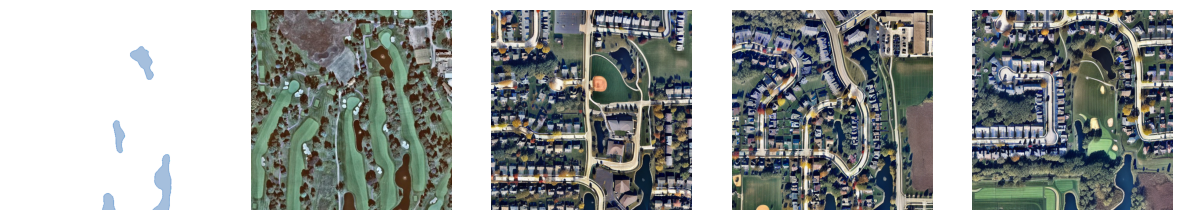

In [10]:
fig, ax = plt.subplots(1,5, figsize=(15, 3))
ax[0].imshow(outputs0[0])
ax[1].imshow(outputs0[1])
ax[2].imshow(outputs0[2])
ax[3].imshow(outputs1[2])
ax[4].imshow(outputs2[2])
for ax in ax.ravel():
    ax.set_axis_off()

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:41<00:00,  2.07s/it]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


(-0.5, 511.5, 511.5, -0.5)

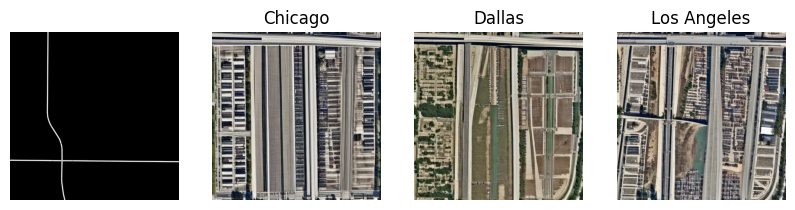

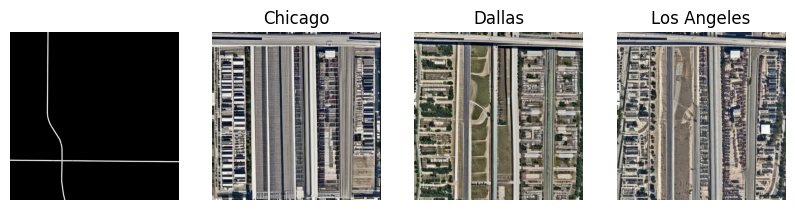

In [9]:
input_city = 'la'
output_city = 'la'
xtile = '11199'
ytile = '26119'

prompt = "Satellite image of a town in Chicago. Landuse parcels include 50 percent residential, 20 percent commercial. High building density. Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,4, figsize=(10, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

prompt = "Satellite image of a town in Dallas. Landuse parcels include 50 percent residential, 20 percent commercial. High building density.  Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

ax[2].set_title("Dallas")
ax[2].imshow(outputs[2])
ax[2].axis('off')

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 50 percent residential, 20 percent commercial. High building density. Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

ax[3].set_title("Los Angeles")
ax[3].imshow(outputs[2])
ax[3].axis('off')

prompt = "Satellite image of a city in Chicago. Landuse parcels include 50 percent residential, 20 percent commercial. High building density. Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,4, figsize=(10, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

prompt = "Satellite image of a city in Dallas. Landuse parcels include 50 percent residential, 20 percent commercial. High building density. Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

ax[2].set_title("Dallas")
ax[2].imshow(outputs[2])
ax[2].axis('off')

prompt = "Satellite image of a city in Los Angeles. Landuse parcels include 50 percent residential, 20 percent commercial. High building density. Medium road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

ax[3].set_title("Los Angeles")
ax[3].imshow(outputs[2])
ax[3].axis('off')


# Design Creativity

Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]
Global seed set to 1024


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.23it/s]


(-0.5, 511.5, 511.5, -0.5)

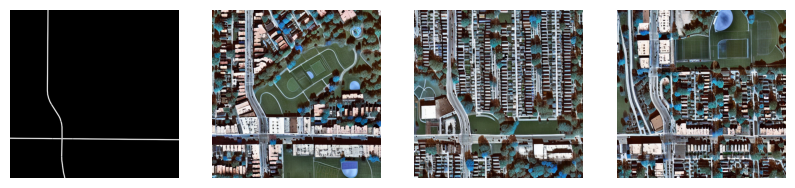

In [15]:
input_city = 'la'
output_city = 'la'
xtile = '11199'
ytile = '26119'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 40 percent residential, 25 percent commercial, 15 percent park. Residential area consists entirely of houses. Low building density. Medium road density."


outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,4, figsize=(10, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

# ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 42, eta)

# ax[2].set_title("Dallas")
ax[2].imshow(outputs[2])
ax[2].axis('off')

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 1024, eta)

# ax[3].set_title("San Francisco")
ax[3].imshow(outputs[2])
ax[3].axis('off')


# Design Constraints

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]


(-0.5, 511.5, 511.5, -0.5)

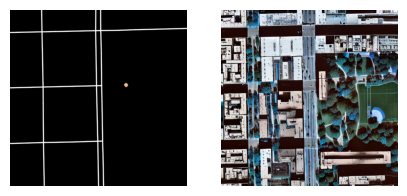

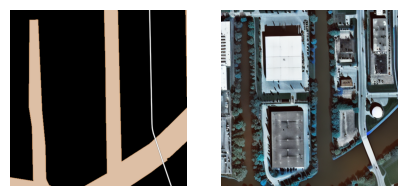

In [10]:
input_city = 'chicago'
output_city = 'chicago'

xtile = '16816'
ytile = '24359'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 15 percent residential, 15 percent commercial, 35 percent park. Residential area consists entirely of apartments. High building density. High road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,2, figsize=(5, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

# ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

xtile = '16809'
ytile = '24365'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 100 percent industrial. Medium building density. Low road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,2, figsize=(5, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

# ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


(-0.5, 511.5, 511.5, -0.5)

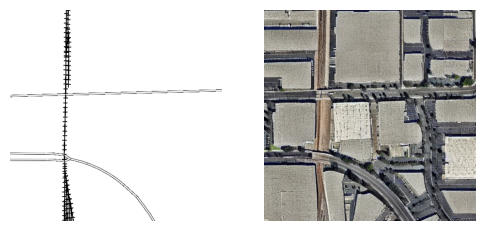

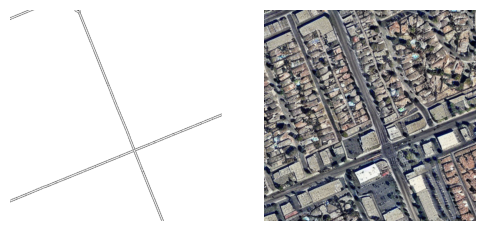

In [11]:
input_city = 'la'
output_city = 'la'

xtile = '11245'
ytile = '26178'

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 100 percent industrial. High building density. Medium road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 42, eta)

fig, ax = plt.subplots(1,2, figsize=(6, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')
ax[1].imshow(outputs[2])
ax[1].axis('off')

xtile = '11223'
ytile = '26142'

prompt = "Satellite image of a town in Los Angeles. Landuse parcels include 60 percent residential, 20 percent commercial. Residential area consists entirely of houses. High building density. Medium road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 42, eta)

fig, ax = plt.subplots(1,2, figsize=(6, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')
ax[1].imshow(outputs[2])
ax[1].axis('off')

# City textures

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
Global seed set to 1024


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


(-0.5, 511.5, 511.5, -0.5)

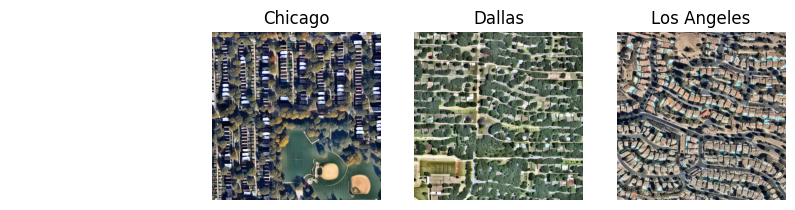

In [12]:
input_city = 'la'
output_city = 'la'

xtile = '11207'
ytile = '26155'

prompt = "Satellite image of a city in Chicago. Landuse parcels include 50 percent residential, 20 percent park. Residential area consists entirely of houses. Medium building density. Low road density."
outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

fig, ax = plt.subplots(1,4, figsize=(10, 3))
ax[0].imshow(outputs[0])
ax[0].axis('off')

ax[1].set_title("Chicago")
ax[1].imshow(outputs[2])
ax[1].axis('off')

prompt = "Satellite image of a city in Dallas. Landuse parcels include 50 percent residential, 20 percent park. Residential area consists entirely of houses. Medium building density. Low road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 42, eta)

ax[2].set_title("Dallas")
ax[2].imshow(outputs[2])
ax[2].axis('off')

prompt = "Satellite image of a city in Los Angeles. Landuse parcels include 50 percent residential, 20 percent park. Residential area consists entirely of houses. Medium building density. Low road density."

outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, 1024, eta)

ax[3].set_title("Los Angeles")
ax[3].imshow(outputs[2])
ax[3].axis('off')


# Ablation Study

Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]
Global seed set to 555


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


Text(0.5, 1.0, 'High')

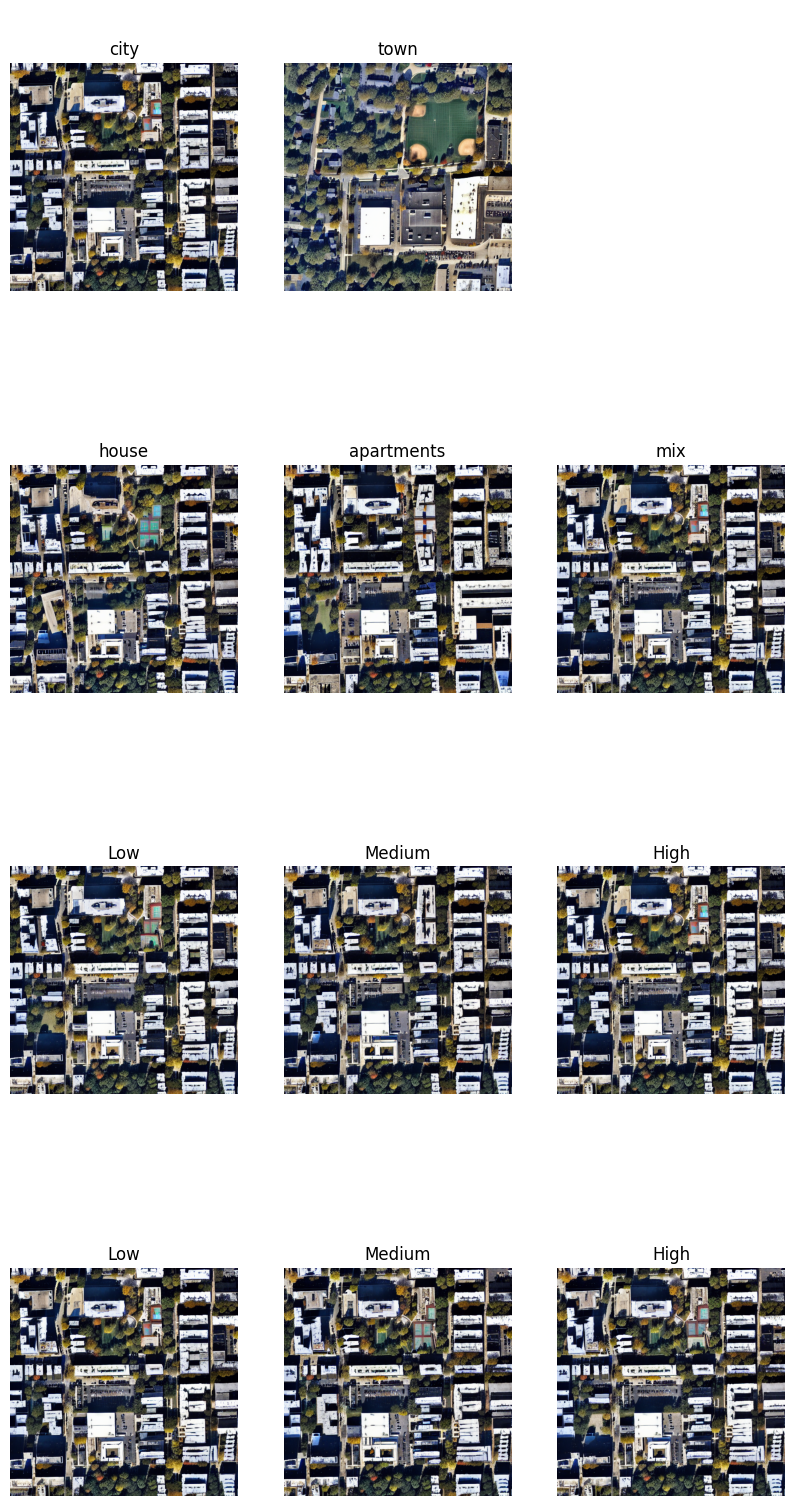

In [13]:
fig, ax = plt.subplots(4, 3, figsize=(10, 20))

# A random tile where hint image is blank
seed = 555
xtile = '16696'
ytile = '24357'
zoom = "16"
input_city = 'chicago'
output_city = 'chicago'

# city/town
prompt1 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Low road density."
prompt2 = "Satellite image of a town in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Low road density."
outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

i = 0
ax[i,0].imshow(outputs1[2])
ax[i,0].axis('off')
ax[i,1].imshow(outputs2[2])
ax[i,1].axis('off')
ax[i,0].set_title("city")
ax[i,1].set_title("town")
ax[i,2].axis('off')

# house/apartment
prompt1 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area consists entirely of houses. High building density. Low road density."
prompt2 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area consists entirely of apartments. High building density. Low road density."
prompt3 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Low road density."

outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt3, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

i += 1
ax[i,0].imshow(outputs1[2])
ax[i,0].axis('off')
ax[i,1].imshow(outputs2[2])
ax[i,1].axis('off')
ax[i,2].imshow(outputs3[2])
ax[i,2].axis('off')
ax[i,0].set_title("house")
ax[i,1].set_title("apartments")
ax[i,2].set_title("mix")

# building density
prompt1 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. Low building density. Low road density."
prompt2 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. Medium building density. Low road density."
prompt3 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Low road density."

outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt3, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

i += 1
ax[i,0].imshow(outputs1[2])
ax[i,0].axis('off')
ax[i,1].imshow(outputs2[2])
ax[i,1].axis('off')
ax[i,2].imshow(outputs3[2])
ax[i,2].axis('off')
ax[i,0].set_title("Low")
ax[i,1].set_title("Medium")
ax[i,2].set_title("High")

# road density
prompt1 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Low road density."
prompt2 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. Medium road density."
prompt3 = "Satellite image of a city in Chicago. Land parcels include 50 percent residential, 30 percent commercial, 20 percent park. Residential area has a mix of apartments and houses. High building density. High road density."

outputs1 = process(xtile, ytile, zoom, input_city, output_city, prompt1, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs2 = process(xtile, ytile, zoom, input_city, output_city, prompt2, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)
outputs3 = process(xtile, ytile, zoom, input_city, output_city, prompt3, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

i += 1
ax[i,0].imshow(outputs1[2])
ax[i,0].axis('off')
ax[i,1].imshow(outputs2[2])
ax[i,1].axis('off')
ax[i,2].imshow(outputs3[2])
ax[i,2].axis('off')
ax[i,0].set_title("Low")
ax[i,1].set_title("Medium")
ax[i,2].set_title("High")



# fig.savefig('./lightning_logs/version_'+version+'/image_log/'+epoch+"-"+step+"_"+input_city+"_"+output_city+"_ablation.png", bbox_inches='tight')

# Generation Results (Random Sample; Generated vs True)

Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.20it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]
Global seed set to 5354


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]


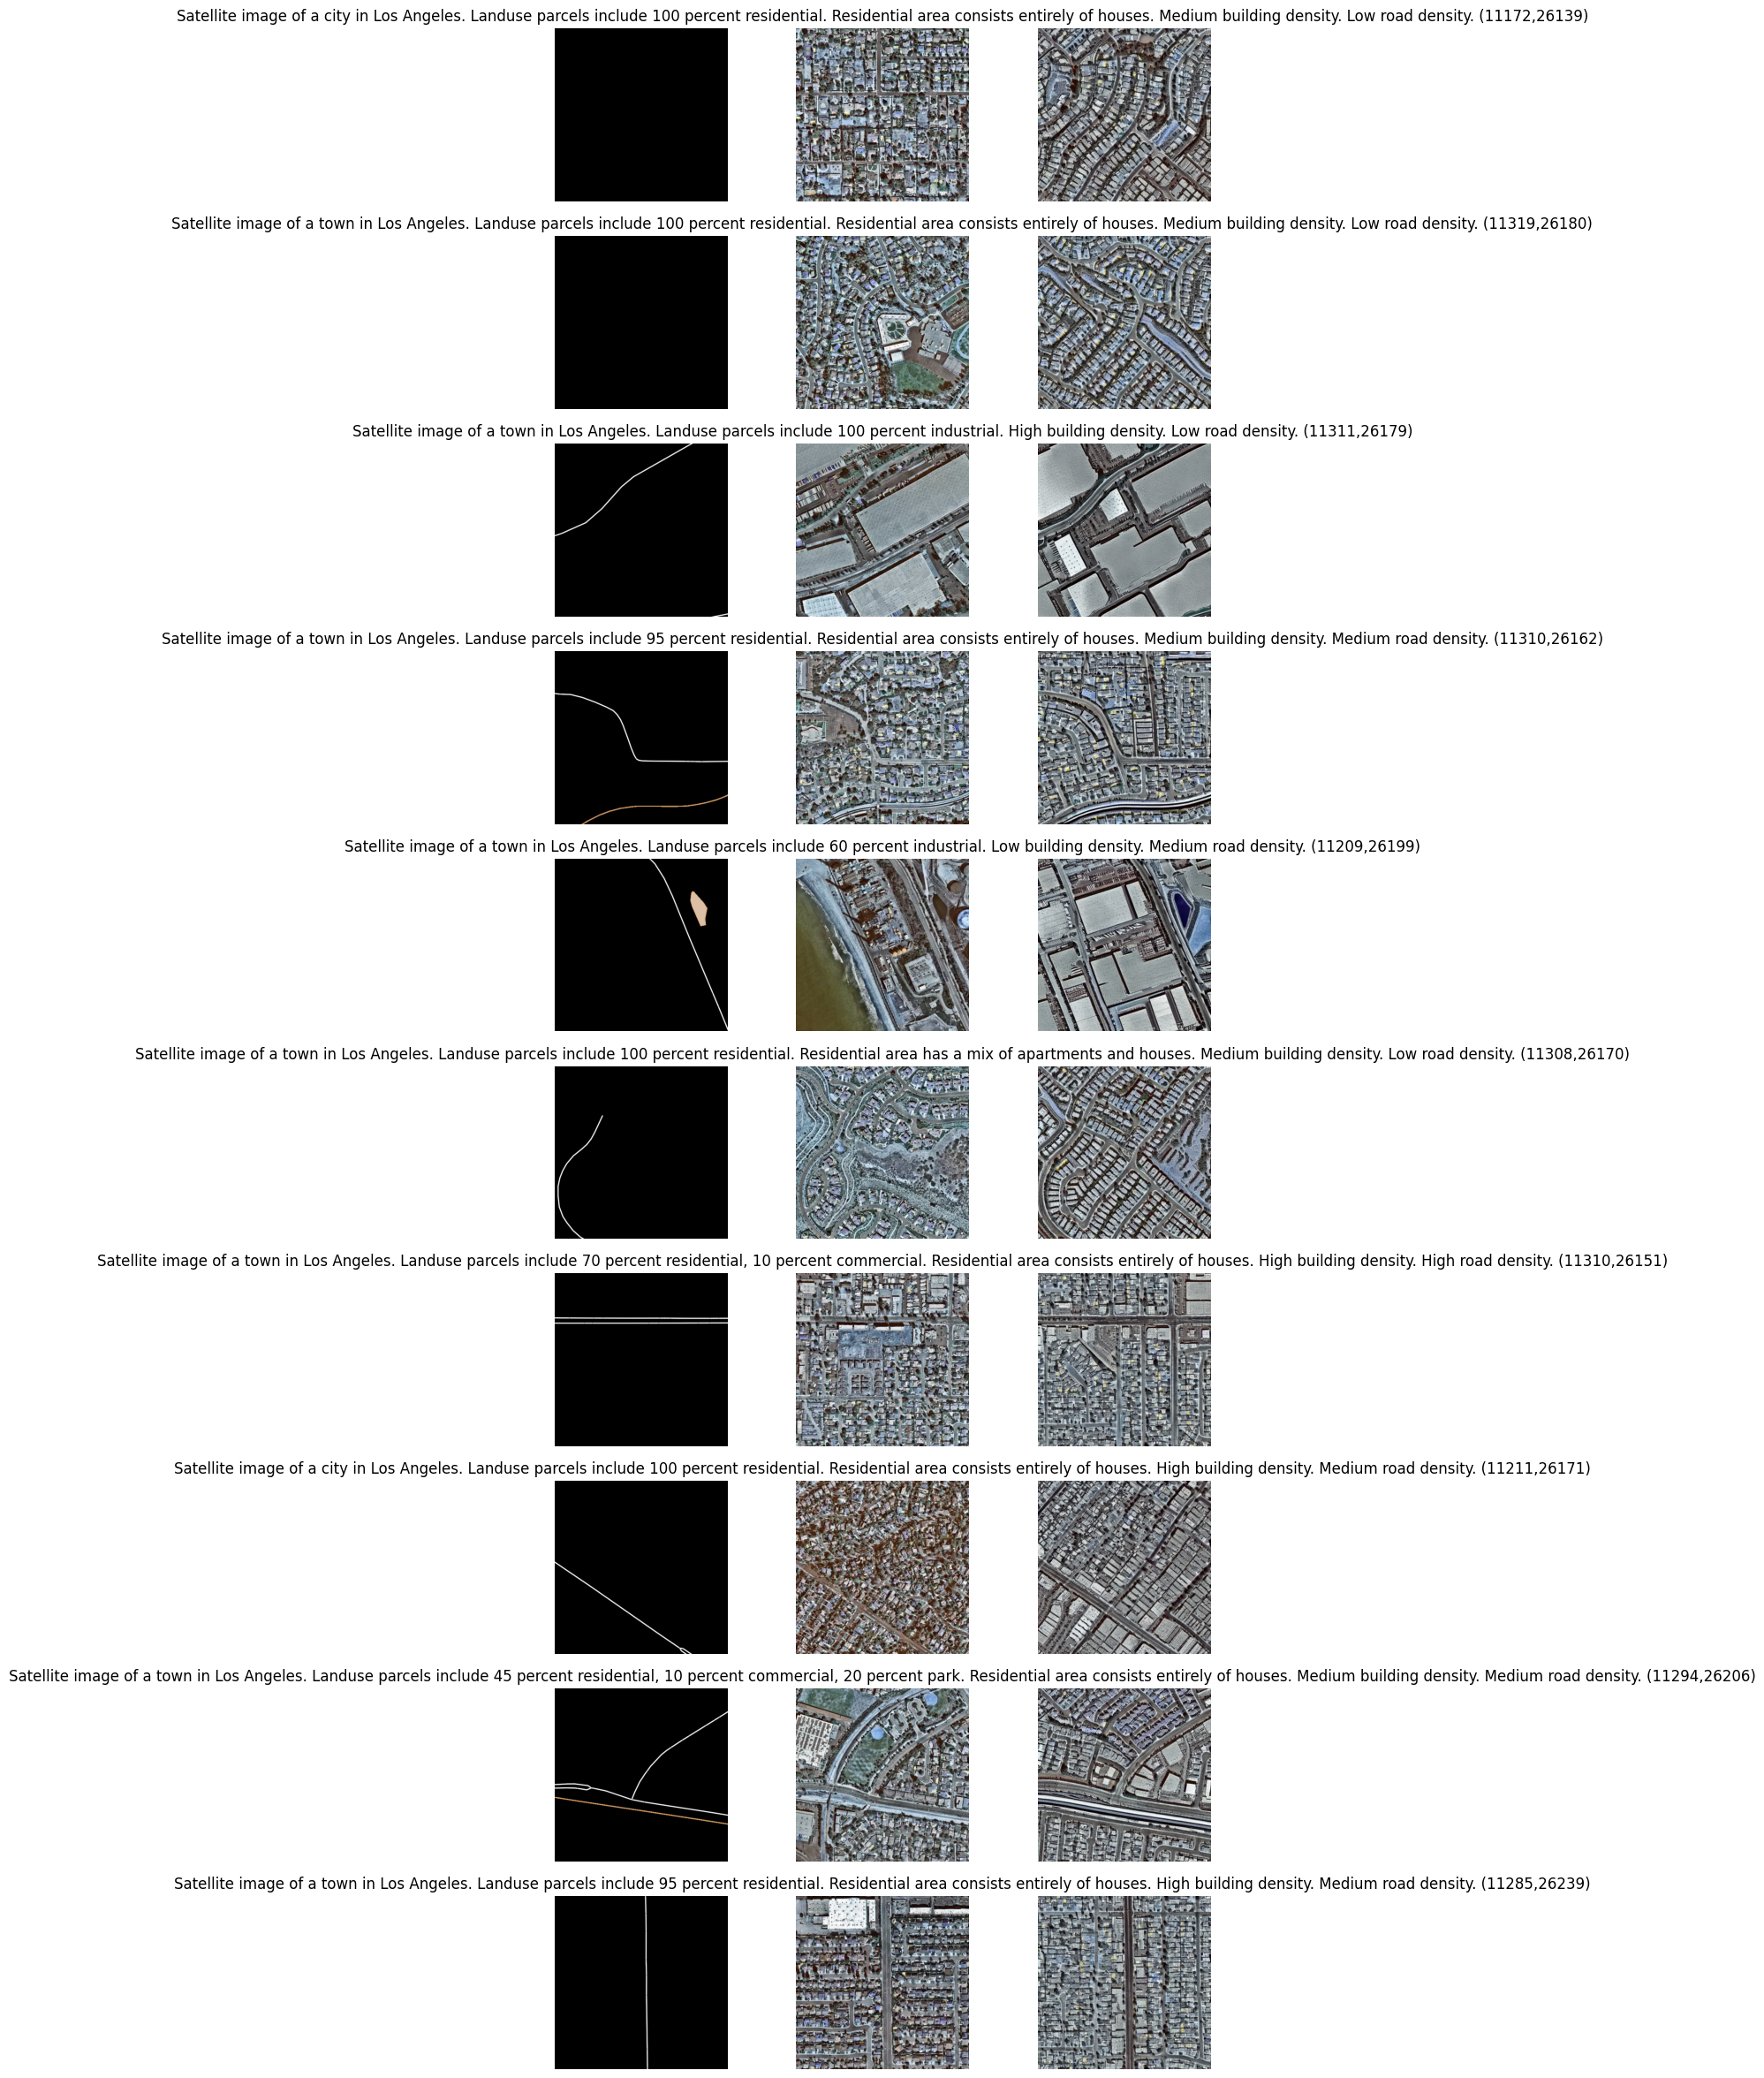

In [27]:
import os
os.makedirs('./lightning_logs/version_'+version+'/image_log/', exist_ok=True)

tile_descriptions = pd.read_csv("~/satellite_tiles_control/tile_descriptions/tile_descriptions_la_1103.csv")
tile_descriptions = tile_descriptions.sample(10, random_state=62)
                                
fig, ax = plt.subplots(10, 3, figsize=(10, 30))
i = 0

for xtile, ytile, city, prompt in zip(tile_descriptions['xtile'], tile_descriptions['ytile'], tile_descriptions['city'], tile_descriptions['final_description']):
    
    xtile = str(xtile)
    ytile = str(ytile)
    zoom = "16"
    input_city = city
    output_city = city

    num_samples = 1
    image_resolution = 512
    strength = 1.0
    guess_mode = False
    detect_resolution = 512
    ddim_steps = 20
    scale = 9.0
    seed = 5354
    eta = 0.0
    a_prompt = 'best quality, extremely detailed'
    n_prompt = 'longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality'

    outputs = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

    
    if input_city != output_city:
        prompt = prompt.replace(city_dic[input_city], city_dic[output_city])
        outputs_1 = process(xtile, ytile, zoom, input_city, output_city, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta)

    ax[i,0].imshow(outputs[0])
    ax[i,0].axis('off')
    if input_city == output_city:
        ax[i,1].imshow(outputs[1])
    else:
        ax[i,1].imshow(outputs_1[2])
    ax[i,1].axis('off')
    ax[i,2].imshow(outputs[2])
    ax[i,2].axis('off')
    if input_city != output_city:
        prompt = prompt.replace(city_dic[input_city], 'X')
    ax[i,1].set_title(prompt+" ("+xtile+","+ytile+")")
    
    i += 1
    
fig.savefig('./lightning_logs/version_'+version+'/image_log/'+epoch+"-"+step+"_"+input_city+"_"+output_city+".png", bbox_inches='tight')